In [1]:
import numpy as np
import pandas as pd
import scipy.stats as sps
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
import statsmodels.api as sm

In [2]:
df = pd.read_csv(
    "https://github.com/fbranda/monkeypox-opendata/raw/main/ECDC-WHO/Epicurves/epicurve_by_country.csv",
    parse_dates=["Date"], index_col="Date"
)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1376 entries, 2022-06-20 to 2022-08-05
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Country  1376 non-null   object
 1   Cases    1376 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 32.2+ KB


In [22]:
df.Country.unique().size

35

In [4]:
WARNINGS = {
    "country": [],
    "1st cases": [],
    "max incidence": [],
    "missing dates": [],
    "length": []
}
DATA = {
    "country": [],
    "1st cases": [],
    "max incidence": [],
    "missing dates": [],
    "length": []
}

for c in df.Country.unique():
    _df = df[df.Country==c]
    WARNINGS["country"].append(c)
    DATA["country"].append(c)
    
    DATA["1st cases"].append(_df.Cases[0])
    if _df.Cases[0] > 1:
        WARNINGS["1st cases"].append("WARN")
    else:
        WARNINGS["1st cases"].append("")
    
    DATA["max incidence"].append(_df.Cases.max())
    if _df.Cases.max() < 10:
        WARNINGS["max incidence"].append("ERR")
    elif _df.Cases.max() < 30:
        WARNINGS["max incidence"].append("WARN")
    else:
        WARNINGS["max incidence"].append("")
        
    missing_dates = pd.date_range(_df.index[0], _df.index[-1]).difference(
        _df.index
    )
    missing_dates_num = missing_dates.size
    DATA["missing dates"].append(missing_dates_num)
    if missing_dates_num:
        WARNINGS["missing dates"].append("WARN")
    else:
        I = _df
        WARNINGS["missing dates"].append("")
        
    WARNINGS["length"].append("")
    DATA["length"].append(0)

In [5]:
WARNINGS = pd.DataFrame(WARNINGS)
DATA = pd.DataFrame(DATA)

In [6]:
countries = WARNINGS[WARNINGS["max incidence"]!="ERR"].country

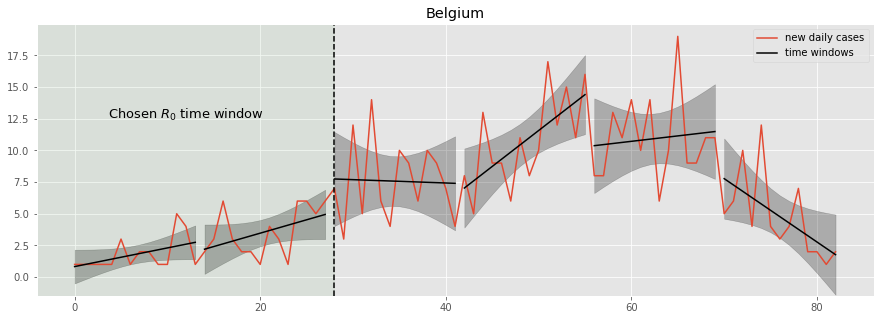

/Users/massimopierini/anaconda3/envs/rem_covid/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1620: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid


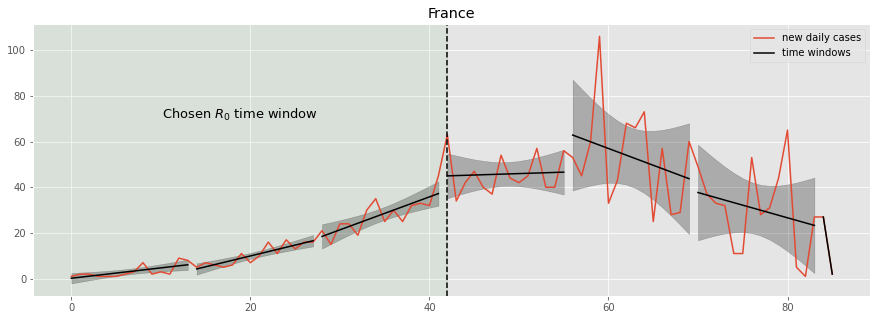

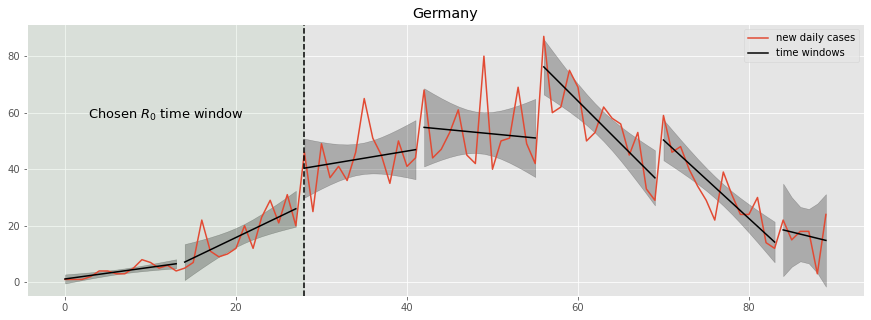

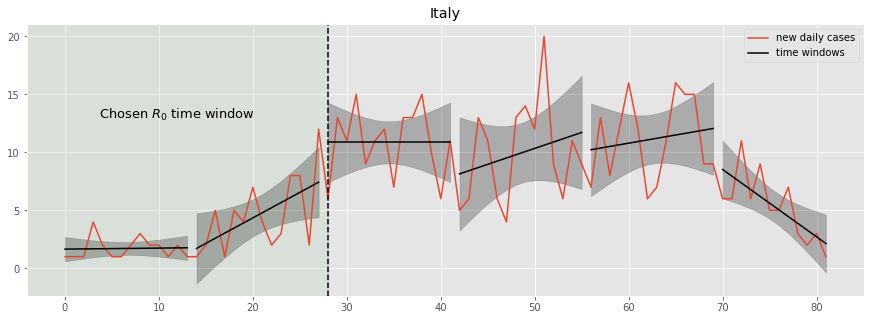

/Users/massimopierini/anaconda3/envs/rem_covid/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1620: RuntimeWarning: invalid value encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid


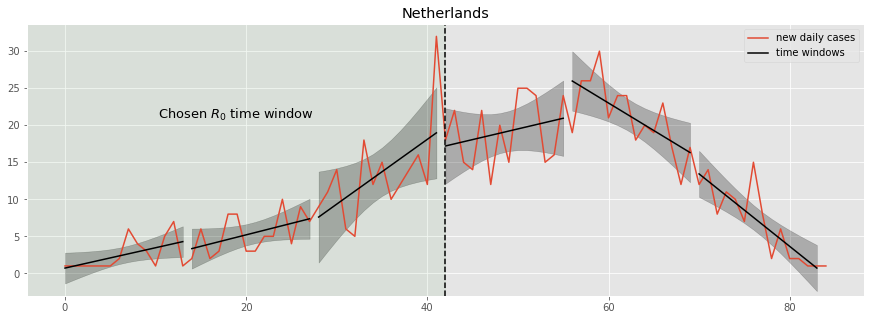

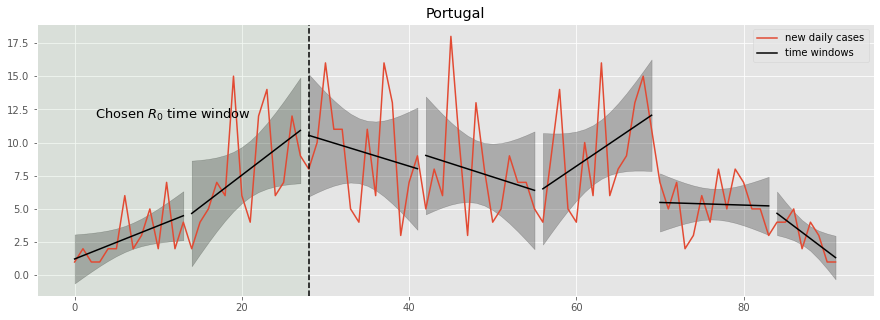

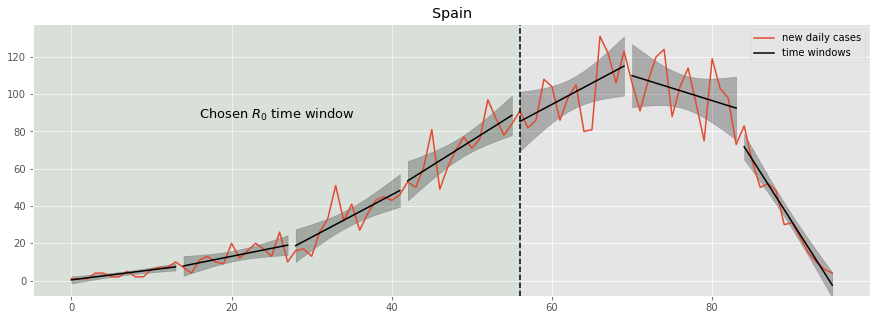

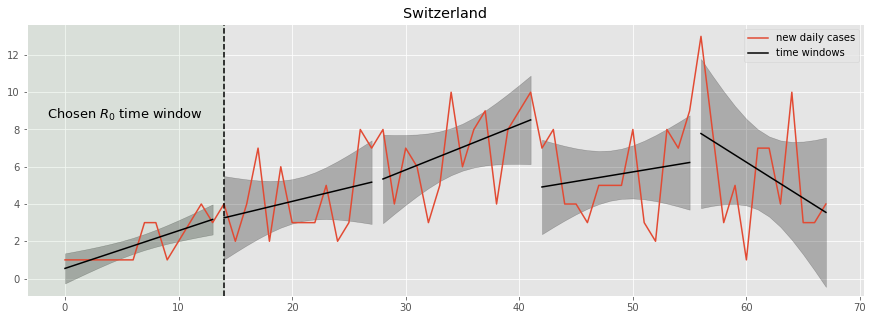

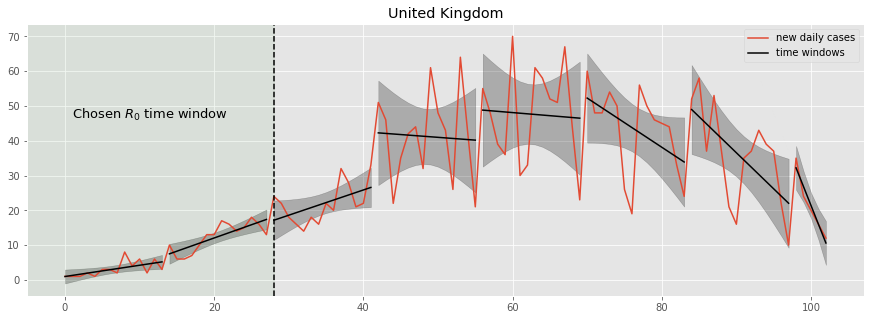

In [71]:
win_size = 14

for country in countries:
    _df = df[df.Country==country].copy(deep=True)
    _df.reset_index(inplace=True)
    _df["Days"] = _df.index
    U = np.arange(_df.index.size // win_size + 1) * win_size
    #U = np.arange(_df.index.size - win_size)
    V = U + win_size
    with plt.style.context("ggplot"):
        fig, ax = plt.subplots(figsize=(15, 5))
        ax = _df.plot(y="Cases", title=country, ax=ax, label="new daily cases")
        #ax.axvline(country_len[country], ls="--", color="k")
        lim = False
        prev_beta1 = 0
        for u, v in zip(U, V):
            win = _df.iloc[u:v]
            mod = sm.OLS.from_formula("Cases ~ Days", data=win)
            fit = mod.fit()
            beta1 = fit.params.Days
            beta1_ci = fit.conf_int(.05)
            pred = fit.get_prediction(win).summary_frame()
            ax.plot(win.index, pred["mean"], "k", label="time windows" if not u else None)
            ax.fill_between(win.index, pred.mean_ci_lower, pred.mean_ci_upper, alpha=.25, color="k")
            if beta1 < prev_beta1 and not lim:
                ax.axvline(u, ls="--", color="k")
                lim = True
                DATA.loc[DATA.country==country, "length"] = u
                if u < 28:
                    WARNINGS.loc[WARNINGS.country==country, "length"] = "WARN"
                xlim = plt.xlim()
                ylim = plt.ylim()
                lox = xlim[0]
                loy = ylim[0]
                height = ylim[1] - loy
                width = u - lox
                ax.add_patch(Rectangle((lox, loy), width, height, color="g", alpha=.05))
                plt.xlim(xlim)
                plt.ylim(ylim)
                plt.text(
                    lox+width/2, loy+2*height/3, "Chosen $R_0$ time window",
                    ha="center", va="center", fontsize=13
                )
            prev_beta1 = beta1
        plt.legend()
        fig.savefig(f"plots/figure1/Window {country}.pdf", bbox_inches="tight")
        plt.show()

In [8]:
DATA

,country,1st cases,max incidence,missing dates,length
0,Andorra,1,1,20,0
1,Austria,1,9,28,0
2,Belgium,1,19,5,28
3,Bosnia and Herzegovina,1,1,0,0
4,Bulgaria,1,1,30,0
5,Croatia,1,3,27,0
6,Cyprus,1,1,0,0
7,Czechia,1,2,70,0
8,Denmark,1,7,35,0
9,Estonia,1,2,30,0


In [9]:
WARNINGS

,country,1st cases,max incidence,missing dates,length
0,Andorra,,ERR,WARN,
1,Austria,,ERR,WARN,
2,Belgium,,WARN,WARN,
3,Bosnia and Herzegovina,,ERR,,
4,Bulgaria,,ERR,WARN,
5,Croatia,,ERR,WARN,
6,Cyprus,,ERR,,
7,Czechia,,ERR,WARN,
8,Denmark,,ERR,WARN,
9,Estonia,,ERR,WARN,


In [10]:
DATA[WARNINGS["max incidence"]!="ERR"]

,country,1st cases,max incidence,missing dates,length
2,Belgium,1,19,5,28
11,France,1,106,3,42
13,Germany,1,87,9,28
19,Italy,1,20,43,28
24,Netherlands,1,32,13,42
27,Portugal,1,18,10,28
31,Spain,1,131,3,56
33,Switzerland,1,13,9,14
34,United Kingdom,1,70,8,28


In [11]:
WARNINGS[WARNINGS["max incidence"]!="ERR"]

,country,1st cases,max incidence,missing dates,length
2,Belgium,,WARN,WARN,
11,France,,,WARN,
13,Germany,,,WARN,
19,Italy,,WARN,WARN,
24,Netherlands,,,WARN,
27,Portugal,,WARN,WARN,
31,Spain,,,WARN,
33,Switzerland,,WARN,WARN,WARN
34,United Kingdom,,,WARN,


In [12]:
def estimate_R0(incidence, country, T=28,
                sh=None, ra=None,
                mu=None, sd=None,
                muLo=None, muUp=None,
                sdLo=None, sdUp=None,
                CI=.95,
                credible_intervals=[.99, .95, .90, .50],
               ):
    
    def R0_posterior(r, credible_intervals):
        R0 = pd.DataFrame()
        R0["Country"] = [country]
        a, loc, scale = sps.gamma.fit(r)
        R_dis = sps.gamma(a=a, loc=loc, scale=scale)
        R_mu = R_dis.mean()
        R_me = R_dis.median()
        R0["Mean"] = [R_mu]
        R0["Median"] = [R_me]
        quantiles = []
        for ci in credible_intervals:
            lo = (1-ci)/2
            up = 1 - lo
            quantiles.append(lo)
            quantiles.append(up)
        for q in sorted(quantiles):
            R_q = R_dis.ppf(q)
            R0[f"Quantile_{q:.3f}"] = [R_q]
        return R0
    
    def sh_ra_from_mu_sd(mu, sd):
        sh = mu**2 / sd**2
        ra = mu / sd**2
        return sh, ra
    
    # define incidence time window
    I = incidence.Cases[:T+1]
    
    # method
    # define mu parameters for Truncated Normal distribution  
    mu_mu = (muUp+muLo)/2
    mu_sd = (muUp-muLo)/2/sps.norm.ppf((1+CI)/2)
    mua, mub = (muLo - mu_mu) / mu_sd, (muUp - mu_mu) / mu_sd
    mu_d = sps.truncnorm(loc=mu_mu, scale=mu_sd, a=mua, b=mub)
    # define sd parameters for Truncated Normal distribution  
    sd_mu = (sdUp+sdLo)/2
    sd_sd = (sdUp-sdLo)/2/sps.norm.ppf((1+CI)/2)
    sda, sdb = (sdLo - sd_mu) / sd_sd, (sdUp - sd_mu) / sd_sd
    sd_d = sps.truncnorm(loc=sd_mu, scale=sd_sd, a=sda, b=sdb)
    # sample (mu,sd) pairs
    mu_rvs = mu_d.rvs(1000)
    mu_sd = []
    for mu_r in mu_rvs:
        sd_r = sd_d.rvs(1)
        while(sd_r >= mu_r):
            sd_r = sd_d.rvs(1)
        mu_sd.append([mu_r, sd_r[0]])
    mu_sd = np.array(mu_sd)
    # init R0 array
    R = []
    # alpha posterior
    a = 1 + np.sum(I[1:])
    # loop through (mu,sd) pairs
    for ms in mu_sd:
        # SI gamma distribution
        _s, _r = sh_ra_from_mu_sd(ms[0], ms[1])
        _dis = sps.gamma(a=_s, scale=1/_r)
        _dis_y = _dis.pdf(np.arange(0,T+1))
        # normalize SI distribution to sum to 1
        _dis_y /= _dis_y.sum()
        # definition of w
        _w = _dis_y
        # beta prior
        b = 1
        for t in range(T)[1:]:
            # lambda
            lam = I[1:t][::-1] * _w[1:t]
            # beta posterior
            b += np.sum(lam)
        # R0 posterior
        R_dis = sps.gamma(a=a, scale=1/b)
        R.append(R_dis.mean())

    # TODO: R > DataFrame with mean, median, mode, .99, .95, .90, .50 CI intervals (+ HDI ?)
    return {"samples": R, "stats": R0_posterior(R, credible_intervals)}

Belgium: missing 5 dates


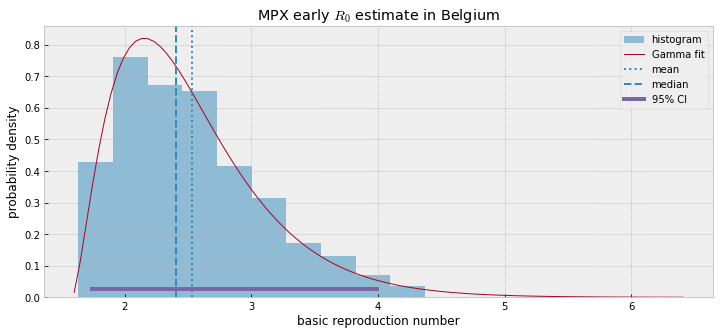

France: missing 3 dates


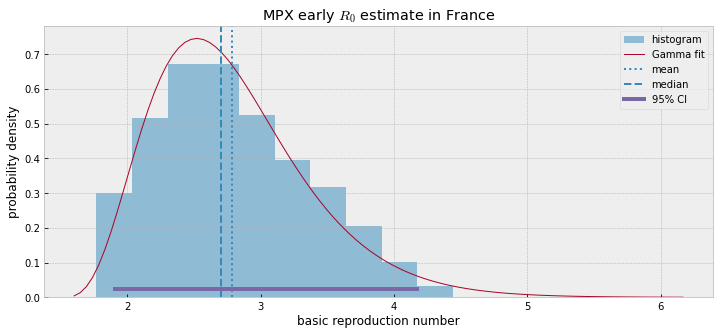

Germany: missing 9 dates


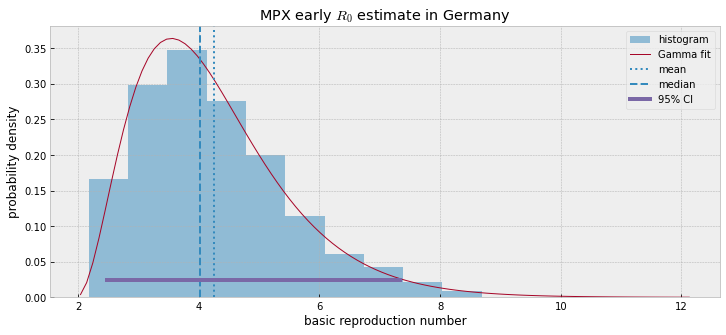

Italy: missing 43 dates


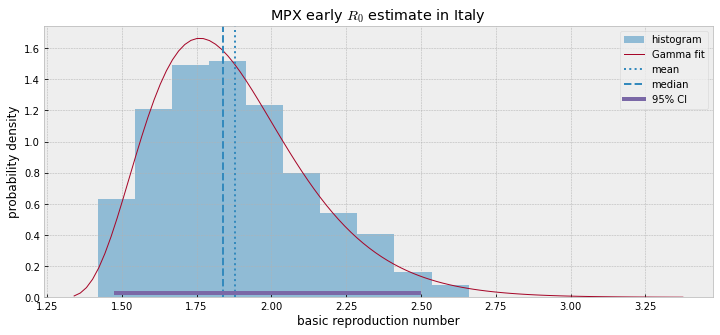

Netherlands: missing 13 dates


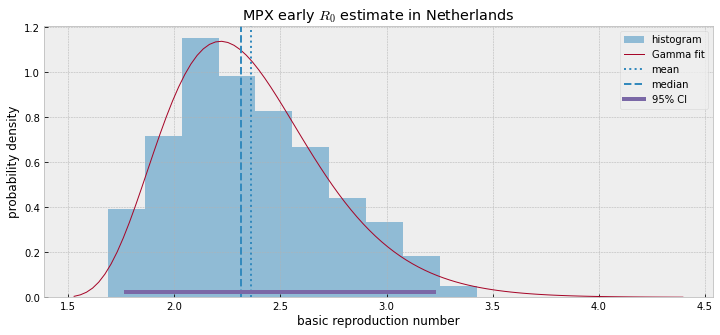

Portugal: missing 10 dates


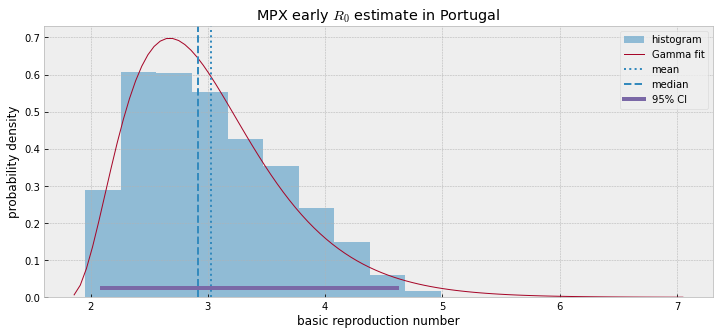

Spain: missing 3 dates


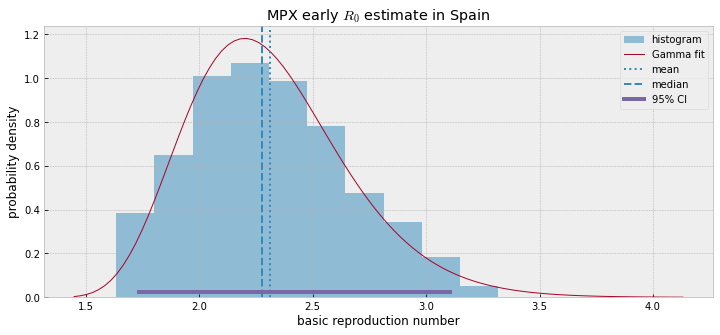

Switzerland: missing 9 dates


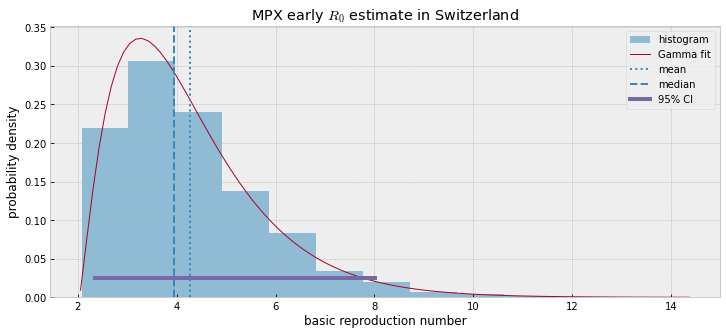

United Kingdom: missing 8 dates


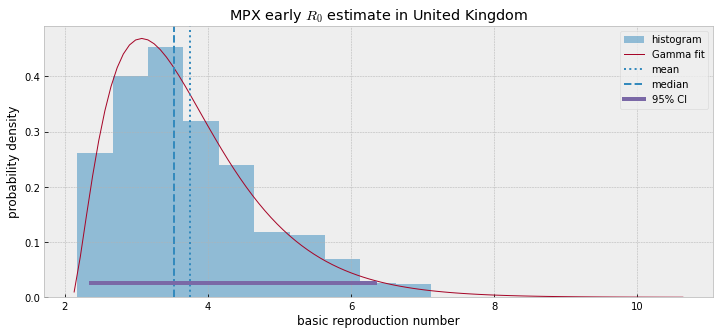

In [72]:
RR = None
Rs = []

for country in countries:
    _df = df[df.Country==country]
    missing_dates = pd.date_range(_df.index[0], _df.index[-1]).difference(
        _df.index
    )
    missing_dates_num = missing_dates.size
    print(f"{country}: missing {missing_dates_num} dates")
    if missing_dates_num:
        I = _df.resample("D").mean().interpolate(method="pchip")
        I["Cases"] = np.ceil(I.Cases).astype(int)

    R = estimate_R0(
        I, country,
        T=DATA.loc[DATA.country==country, "length"].values[0],
        muLo=7.55, muUp=17.29,
        sdLo=2.88, sdUp=7.26
    )
    if RR is None:
        RR = R["stats"]
    else:
        RR = pd.concat([RR, R["stats"]])
    Rs = np.concatenate([Rs, R["samples"]])
    
    a, loc, scale = sps.gamma.fit(R["samples"])
    R_dis = sps.gamma(a=a, loc=loc, scale=scale)
    R_x = np.linspace(R_dis.ppf(.0001), R_dis.ppf(.9999), 100)
    R_y = R_dis.pdf(R_x)
    
    with plt.style.context("bmh"):
        fig, ax = plt.subplots(figsize=(12, 5))
        plt.hist(R["samples"], alpha=.5, density=True, label="histogram")
        plt.plot(R_x, R_y, lw=1, label="Gamma fit")
        plt.axvline(R_dis.mean(), ls=":", label="mean")
        plt.axvline(R_dis.median(), ls="--", label="median")
        R_lo = R_dis.ppf(.025)
        R_up = R_dis.ppf(.975)
        plt.plot([R_lo, R_up], [.025, .025], lw=4, label="95% CI")
        plt.legend()
        plt.title(f"MPX early $R_0$ estimate in {country}")
        plt.xlabel("basic reproduction number")
        plt.ylabel("probability density")
        fig.savefig(f"plots/figure2/R0 {country}.pdf", bbox_inches="tight")
        plt.show()

In [52]:
RR

,Country,Mean,Median,Quantile_0.005,Quantile_0.025,Quantile_0.050,Quantile_0.250,Quantile_0.750,Quantile_0.950,Quantile_0.975,Quantile_0.995
0,Belgium,2.538167,2.422723,1.638075,1.728976,1.794503,2.099785,2.851839,3.676235,4.000027,4.716085
0,France,2.730051,2.635736,1.784740,1.902350,1.980468,2.312103,3.045841,3.801744,4.091829,4.724778
0,Germany,4.334411,4.073848,2.313136,2.516267,2.662975,3.347946,5.039415,6.896054,7.625622,9.239485
0,Italy,1.866895,1.831747,1.403158,1.471369,1.513757,1.680365,2.015272,2.340029,2.461695,2.723360
0,Netherlands,2.364319,2.319200,1.669166,1.779231,1.845644,2.097758,2.581860,3.037007,3.205345,3.564528
0,Portugal,2.998642,2.883165,1.984614,2.098545,2.177321,2.527422,3.344944,4.214420,4.552142,5.294255
0,Spain,2.289735,2.251401,1.601727,1.717521,1.785700,2.037045,2.500747,2.924606,3.079489,3.407471
0,Switzerland,4.237049,3.933506,2.199847,2.375371,2.509905,3.181519,4.965326,7.001421,7.812689,9.621359
0,United Kingdom,3.820704,3.604405,2.144125,2.312487,2.434120,3.002205,4.405559,5.946264,6.551730,7.891128


In [66]:
RRc = RR.copy(deep=True)
RRc.columns = RRc.columns.str.replace("Quantile_", "Q_")

In [67]:
RRc.set_index("Country").round(2).to_csv("R0.csv")

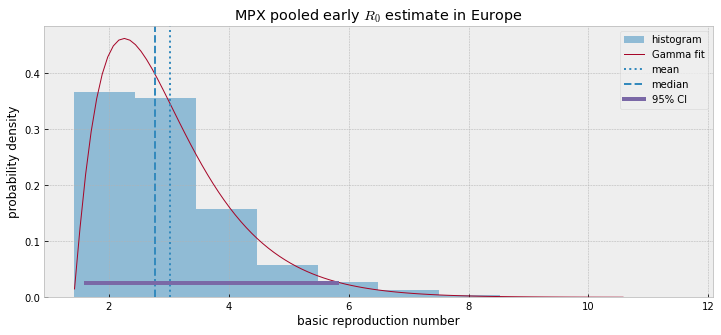

In [73]:
with plt.style.context("bmh"):
    fig, ax = plt.subplots(figsize=(12, 5))
    plt.hist(Rs, alpha=.5, density=True, label="histogram")
    a, loc, scale = sps.gamma.fit(Rs)
    Rs_d = sps.gamma(a=a, loc=loc, scale=scale)
    Rs_x = np.linspace(Rs_d.ppf(.0001), Rs_d.ppf(.9999), 100)
    Rs_y = Rs_d.pdf(Rs_x)
    plt.plot(Rs_x, Rs_y, lw=1, label="Gamma fit")
    plt.axvline(Rs_d.mean(), ls=":", label="mean")
    plt.axvline(Rs_d.median(), ls="--", label="median")
    Rs_lo = Rs_d.ppf(.025)
    Rs_up = Rs_d.ppf(.975)
    plt.plot([Rs_lo, Rs_up], [.025, .025], lw=4, label="95% CI")
    plt.legend()
    plt.title("MPX pooled early $R_0$ estimate in Europe")
    plt.xlabel("basic reproduction number")
    plt.ylabel("probability density")
    fig.savefig("plots/figure0/R0_EU.pdf", bbox_inches="tight")
    plt.show()

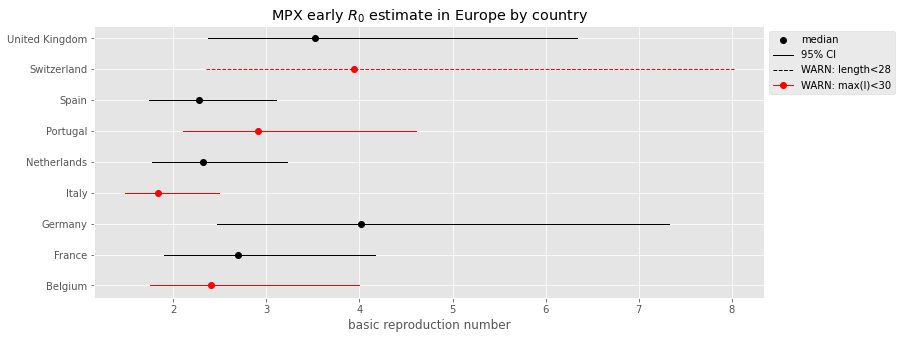

In [74]:
with plt.style.context("ggplot"):
    fig, ax = plt.subplots(figsize=(12, 5))
    for c in RR.Country.unique():
        _R = RR[RR.Country==c]
        color = "k"
        ls = "-"
        if WARNINGS[WARNINGS.country==c]["max incidence"].values[0] == "WARN":
            color = "r"
        if WARNINGS[WARNINGS.country==c].length.values[0] == "WARN":
            ls = "--"
        ax.plot(_R.Median, c, 'o', c=color)
        ax.plot(
            [_R["Quantile_0.025"].values[0], _R["Quantile_0.975"].values[0]], [c, c], 
            lw=1, color=color, ls=ls)
        plt.title("MPX early $R_0$ estimate in Europe by country")
    plt.xlabel("basic reproduction number")
    legend = [
        Line2D([0], [0], marker='o', color='k', label='median', markerfacecolor='k', lw=0),
        Line2D([0], [0], color='k', label='95% CI', markerfacecolor='k', lw=1),
        Line2D([0], [0], color='k', label='WARN: length<28', lw=1, ls="--"),
        Line2D([0], [0], marker='o', color='r', label='WARN: max(I)<30', markerfacecolor='r', lw=1),
    ]
    plt.legend(handles=legend, loc="upper left", bbox_to_anchor=(1,1))
    fig.savefig("plots/figure0/R0_countries.pdf", bbox_inches="tight")
    plt.show()

In [21]:
string = ""
for c in countries.values:
    string += c+", "
string

'Belgium, France, Germany, Italy, Netherlands, Portugal, Spain, Switzerland, United Kingdom, '

In [24]:
countries.size

9

In [40]:
DATA.columns

Index(['country', '1st cases', 'max incidence', 'missing dates', 'length'], dtype='object')

In [36]:
DW = pd.DataFrame()

In [37]:
DW["country"] = DATA.country

In [38]:
DW["1st cases"] = DATA["1st cases"].astype(str) + " " + WARNINGS["1st cases"]

In [41]:
DW["max incidence"] = DATA["max incidence"].astype(str) + " " + WARNINGS["max incidence"]

In [43]:
DW["missing dates"] = DATA["missing dates"].astype(str) + " " + WARNINGS["missing dates"]

In [45]:
DW["length"] = DATA["length"].astype(str) + " " + WARNINGS["length"]

In [47]:
DW.set_index("country")

,1st cases,max incidence,missing dates,length
country,,,,
Andorra,1,1 ERR,20 WARN,0
Austria,1,9 ERR,28 WARN,0
Belgium,1,19 WARN,5 WARN,28
Bosnia and Herzegovina,1,1 ERR,0,0
Bulgaria,1,1 ERR,30 WARN,0
Croatia,1,3 ERR,27 WARN,0
Cyprus,1,1 ERR,0,0
Czechia,1,2 ERR,70 WARN,0
Denmark,1,7 ERR,35 WARN,0


In [49]:
DW.to_csv("countries.csv")